In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests


import torch
import torch.nn as nn
import torch.nn.functional as F

# use GPU
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [2]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

/Users/raeez/.pyenv/versions/jupyter-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# hyper para for GPT2-124M
n_vocab = 50257 # GPT2 vocab size
embed_dim = 768 #embedding dim
seq_len = 256 #max seq len
n_heads = 12 # attention heads
n_blocks = 12 # tranformer blocks
#each transformer block has 12 atention heads
batch_size = 16

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [9]:
# Import tokenzie and split text (Gullivers travels)

text = requests.get('https://www.gutenberg.org/cache/epub/829/pg289.txt').text
print(len(text))
gtTokens = torch.tensor(tokenizer.encode(text), dtype = torch.long)
len(gtTokens)

6511


2887

In [24]:
# train/test split
train_ratio = .9

#index to split data
test_split_point = int(train_ratio * len(gtTokens))

train_data = gtTokens[:test_split_point]
test_data = gtTokens[test_split_point:]
# in this split 10% of the last part is training set, whi9ch is not a good split
# ideally we would want a random split


# a func that return a batch of data samoples
def get_data_batch(training = True):
    # pick the dataset to use
    if training:
        data = train_data
    else:
        data = test_data

    #pick random idices to start
    ix = torch.randint(len(data) - seq_len, size = (batch_size,))

    #get the data and targets (via broadcasting outer product)
    X = data[ix[:,None] + torch.arange(seq_len)]  # now this is becomes a matrix
    y = data[ix[:,None] + torch.arange(1,seq_len+1)]

    return X,y

#example 
X,y = get_data_batch()
print(f'Input data (size {X.shape}):\n',X)
print(f'\n\nTargets (size {y.shape}):\n',y)

Input data (size torch.Size([16, 256])):
 tensor([[45486,  3556,    64,  ..., 35922, 30586,    14],
        [   13,    20,  1478,  ...,   220,   220,   220],
        [ 2695,  2625,   732,  ...,     1,  4686,  2625],
        ...,
        [   12, 18741,    87,  ...,   220,   220,   220],
        [15414,   198,   220,  ...,    12, 11299,  5320],
        [15414,     1,   198,  ...,  1988,  2625,    55]])


Targets (size torch.Size([16, 256])):
 tensor([[ 3556,    64,   198,  ..., 30586,    14, 13776],
        [   20,  1478,    89,  ...,   220,   220,  2223],
        [ 2625,   732, 12485,  ...,  4686,  2625, 10755],
        ...,
        [18741,    87,  1795,  ...,   220,   220,   220],
        [  198,   220,   220,  ..., 11299,  5320,   198],
        [    1,   198,   220,  ...,  2625,    55,    42]])


In [11]:
ix = torch.randint(250 - 12, size = (5,))

In [15]:
ix

tensor([ 61,  92, 182, 159, 237])

In [13]:
ix[:,None] #transformerd to col vector

tensor([[ 61],
        [ 92],
        [182],
        [159],
        [237]])

In [21]:
ix[:,None] + torch.arange(12)

tensor([[ 61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72],
        [ 92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103],
        [182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193],
        [159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170],
        [237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248]])

In [22]:
train_data[ix[:,None] + torch.arange(12)]

tensor([[    1, 13291, 35922,    70, 19028,    14,  7635,    17,    13, 25471,
            30,    85],
        [ 1686,   856,    13, 25471,    30,    16,    13,    18,  5320,   198,
          1279,  8726],
        [    1,  2695,  2625, 12106,    11,   304, 12106,    11,  1479,    11,
          1611,   293],
        [  634,     1,  2695,  2625, 10394,    28, 25202,    12, 10394,    11,
          4238,    12],
        [   12,    16,    76, 36392,    70,    12, 20692, 15916,    24,   952,
          5320,   198]])

In [30]:
train_data[63]

tensor(35922)

# prepare model5

In [25]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        
        super().__init__()
    
        #head dimensionality is embed_dim split across the heads
        self.num_heads = n_heads
        self.head_dim = embed_dim // n_heads
    
        # the three Q,K,V weight matrices are init as one, and are split inside attention eqn
        self.QKV = nn.Linear(embed_dim, 3*embed_dim, bias=True)
    
        #final linear projection merges the heads outputs
        self.W0 = nn.Linear(embed_dim, embed_dim, bias=True)
    
    def forward(self, x):
        # extract the dimension size of the inputs(token embedds)
        B, T, E = x.shape # [batch, tokens (or seq_len), embed_dim]
        

        #push data through Q,K and V in one concatenated matrix
        qkv = self.QKV(x) #[batch, seq_len, 3*embed]
        q,k,v = torch.split(qkv, E, dim=2) # each matrix is [B,T,E]

        # reshape to [B,T,nHeads, head_dim]
        # and then transpose to [B, nHeads, T, head_dim]
        q = q.view(B, T, self.num_heads, self.head_dim).transpose(1,2) #[B, num_heads, T, head_dim]
        k = k.view(B, T, self.num_heads, self.head_dim).transpose(1,2)
        v = v.view(B, T, self.num_heads, self.head_dim).transpose(1,2)

        # Pytorchs SDPA func handles multi head shapes
        out = F.scaled_dot_product_attention(q,k,v,is_causal=True)

        # recombine heads : (B,nHeads,T,head_dim) -> [B,T,E]
        out = out.transpose(1,2).reshape(B,T,E)
    

        #finallt apply linear mixing matrix
        out = self.W0(out)

        return out

class TransformerBlock(nn.Module):
    def __init__(self):
        super().__init__()

        #attention subblock
        self.layernorm_1 = nn.LayerNorm(embed_dim,eps=1e-5)
        self.attn = MultiHeadAttention()

        #feedfwd (MLP) sublayer
        self.layernorm_2 = nn.LayerNorm(embed_dim,eps=1e-5)
        self.mlp_1 = nn.Linear(embed_dim,4*embed_dim,bias=True) # 4x expansion
        self.gelu = nn.GELU()
        self.mlp_2 = nn.Linear(4*embed_dim, embed_dim, bias=True) #4x contraction

    def forward(self,x):

        ## ----attention sublayer ------##
        x_att = self.layernorm_1(x) # pre attn normalisn
        x_att = x + self.attn(x_att) # run through attention, then add pre attn activations

        #MLP
        x_ff = self.layernorm_2(x_att) # pre MLP normlsn
        x_ff = x_att + self.mlp_2( self.gelu( self.mlp_1(x_ff)))
        
        return x_ff
        
        

In [26]:
# the full model class, which calls the previously defined classes
class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()

        # token + posn embedds
        self.wte = nn.Embedding(n_vocab, embed_dim) # token embedds
        self.wpe = nn.Embedding(seq_len, embed_dim) # posn embedds

        #n mutliple Transformer blocks
        # * is a unpacking operator, the list of txf blocks goes into input of Sequential()
        self.transformerBlocks = nn.Sequential(*[TransformerBlock() for _ in range(n_blocks)])

        # embedding to output (linear) layer
        self.layernorm_final = nn.LayerNorm(embed_dim,eps=1e-5) # final layernorm after all txf blocks
        #unembed matirx
        self.final_head = nn.Linear(embed_dim, n_vocab, bias=False)
        #final ouput layer (unembedd) tied to token embedd
        self.final_head.weight = nn.Parameter(self.wte.weight)

    def forward(self, idx):

        #----------embeddings-------------##
        token_emb = self.wte(idx)  # [B,T,E]   T is seq_len and E is embed_dim
        posit_emb = self.wpe(torch.arange(idx.shape[-1],device=device)) #[seq_len, embed_dim]
        x = token_emb + posit_emb #[B,T,E]
        ##--------------------------------##

        #n
        ##--pass through each transformer blocks----##
        x = self.transformerBlocks(x)
        ##-------------------------##

        #-----finally unembeddings----##
        x = self.layernorm_final(x)
        logits = self.final_head(x) # [B,T, n_vocab]
        # logits is [batch, seq_len, n_vocab]
        return logits

    def generate(self,idx,temperature=1.,max_new_tokens=50):
        for _ in range(max_new_tokens):
            # fwd passb
            logits = self(idx[:,-seq_len:]) # [B,T,n_vocab]   get preds, but only from past seq_len tokens 
            logits = logits[:,-1,:] #[B,n_vocab]   extract last tokens logitsto predict the next

            # apply softmax with temp to get prob values over all tokens in vocab - with temp
            probs = F.softmax(logits/temperature,dim=-1) #[B,n_vocab]

            #probabilistically sample next token from distbn
            idx_next = torch.multinomial(probs, num_samples=1) # [batch,1]
            
            #append 
            idx = torch.cat((idx, idx_next),dim=1) #[batch, (tokens+1)]
        return idx

In [27]:
model = LanguageModel().to(device)
X, y = get_data_batch()
X,y = X.to(device), y.to(device)
out = model(X)
print(f'input size: {X.shape}')
print(f'output  size: {out.shape}')

input size: torch.Size([16, 256])
output  size: torch.Size([16, 256, 50257])


In [35]:
# generate new text before any training
startToks = torch.tensor(tokenizer.encode('The man-mountain shall not depart from our dominion')).unsqueeze(0)

# text gen
Y = model.generate(startToks.to(device), max_new_tokens=100)
print(tokenizer.decode(Y[0].tolist()).replace('\r','\n'))

The man-mountain shall not depart from our dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion dominion


tensor([  464,   582,    12, 14948,   391,  2236,   407,  6313,   422,   674,
        43866])

Training the model

In [36]:

# create loss and omptimizer funcitons
loss_function = nn.NLLLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=.001, weight_decay=.01)  

In [38]:
# check loss func with sizes
X,y = get_data_batch()
X = X[0].unsqueeze(0)
y = y[0].unsqueeze(0)
log_probs = model(X.to(device))

print(f'Model inout size: {X.shape}')
print(f'Model out size: {log_probs.shape}')
print(f'Target tokens is  size: {y.shape}')

# flatten
log_probs_flat = log_probs.view(-1, log_probs.shape[-1])

loss  = loss_function(log_probs_flat, y.view(-1).to(device))
print('\nLoss:', loss)

Model inout size: torch.Size([1, 256])
Model out size: torch.Size([1, 256, 50257])
Target tokens is  size: torch.Size([1, 256])

Loss: tensor(-70.6043, device='mps:0', grad_fn=<NllLossBackward0>)


Now train model

In [ ]:
num_samples = 501

#init the loss
train_loss = np.zeros(num_samples)
test_loss = np.zeros(num_samples)

for sampli in range(num_samples):
    # get batch of data
    X,y = get_data_batch()

    X,y = X.to(device), y.to(device)
    model.zero_grad()

    #fwd pass
    log_probs = model(X)
    log_probs_flat = log_probs.view(-1, log_probs.shape[-1])  #tokens 0:N-1
    y_flat = y.view(-1) # tokens 1:N
    loss = loss_function(log_probs_flat,y_flat)
    # loss = loss_function(log_probs.view(-1, log_probs.shape[-1]),y.view(-1))

    #bckprop
    loss.backward()
    optimizer.step()

    # sum the batch loss
    train_loss[sampli] = loss.item()

    if sampli%100==0:
        with torch.no_grad():
            
            X,y = get_data_batch(False)
            X,y = X.to(device), y.to(device)
            out = model(X)
            out_flat = out.reshape(-1, out.shape[-1])
            thisloss = loss_function(out_flat, y.view(-1))
            
            # thisloss = loss_function(out.view(-1, out.shape[-1]), y.view(-1))
            test_loss[sampli] = thisloss.item()

            print(f'Sample {sampli} train loss: {train_loss[sampli]}, test loss:m{test_loss[sampli]}')

Sample 0 train loss: -1758.351806640625, test loss:m-1159.348876953125


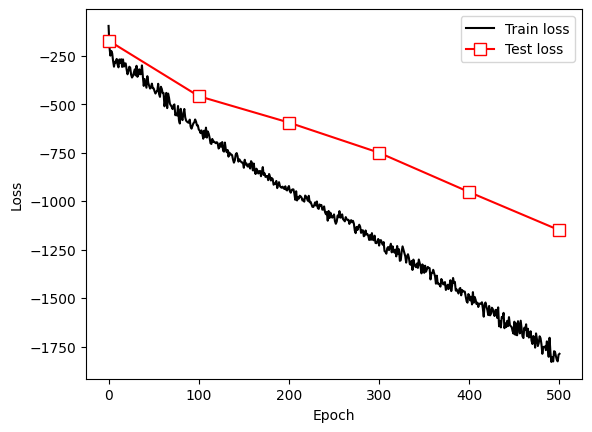

In [41]:
plt.plot(train_loss, 'k',label='Train loss')
plt.plot(range(0, num_samples, 100), test_loss[::100], 'rs-', markerfacecolor= 'w', markersize=8,label='Test loss')

plt.legend()
plt.gca().set(xlabel='Epoch', ylabel='Loss')
plt.show()


In [42]:
# generate new text before any training
startToks = torch.tensor(tokenizer.encode('The man-mountain shall not depart from our dominion')).unsqueeze(0)

# text gen
Y = model.generate(startToks.to(device), max_new_tokens=100)
print(tokenizer.decode(Y[0].tolist()).replace('\r','\n'))

The man-mountain shall not depart from our dominionl.34a6.5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
